# Fremont Bridge Hourly Bicycle Counts by Month October 2012 to present

The Fremont Bridge Bicycle Counter records the number of bikes that cross the bridge using the pedestrian/bicycle pathways. Inductive loops on the east and west pathways count the passing of bicycles regardless of travel direction. The data consists of a date/time field: Date, east pathway count field: Fremont Bridge NB, and west pathway count field: Fremont Bridge SB. The count fields represent the total bicycles detected during the specified one hour period. Direction of travel is not specified, but in general most traffic in the Fremont Bridge NB field is travelling northbound and most traffic in the Fremont Bridge SB field is travelling southbound. Get data from https://data.seattle.gov/ site.


### Unsupervised Analysis of Days of Week

Treating bicycles crossings each day as features to learn about the relationships between various days.

pip install sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

# Plotting data points into jupyter notebook itself rather than a separate window
%matplotlib inline

# Set the plot style

plt.style.use('seaborn')

C:\Users\PC\AppData\Local\Temp\ipykernel_15476\1063327117.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Get Fremont data

#### Help on fremont_data package

* get_fremont_data? gives methods signature in intellisense (press shift+tab)
* get_fremont_data?? gives documentation as well as source code of the method (press shift+tab twice)

In [2]:
import os
import pandas as pd
from urllib.request import urlretrieve

# Data url
FREMONT_URL = 'https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD'

def get_fremont_data(filename= 'Fremont.csv', url = FREMONT_URL, force_download=False):
	
	"""Download and cache Fremont Data
	
	Parameters
	----------
	filename : string (optional)
		Location to save the data
	url : string (optional)
		Web location of the data		
	force_download	: bool(optional)
		if True, Force re-download of data 
	
	Returns
	-------
	data : pandas.DataFrame
		The Fremont Bridge Data	
	"""	
	if force_download or not os.path.exists(filename):
		urlretrieve(url, filename)
	
	# read csv file
	data = pd.read_csv(filename, index_col='Date')
	
	# parse date column and use it as index column
	try:
		data.index = pd.to_datetime(data.index, format='%m/%d/%Y %I:%M:%S %p')
	except TypeError:
		data.index = pd.to_datetime(data.index)
	
	data.columns = ["Total",'West', 'East']
	# Sum of the counts of bicycles on East and West sides
	#data['Total'] = data['West'] + data['East']
	return data

data =  get_fremont_data('Fremont.csv', FREMONT_URL, False)
data.head(5)

,Total,West,East
Date,,,
2022-08-01 00:00:00,23.0,7.0,16.0
2022-08-01 01:00:00,12.0,5.0,7.0
2022-08-01 02:00:00,3.0,0.0,3.0
2022-08-01 03:00:00,5.0,2.0,3.0
2022-08-01 04:00:00,10.0,2.0,8.0


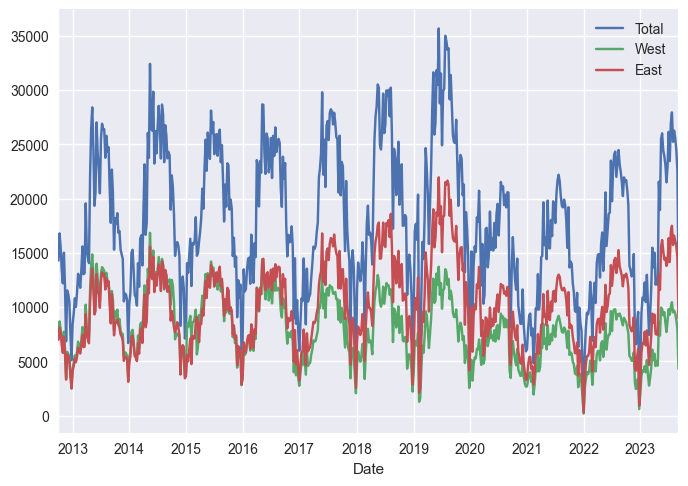

In [3]:
data.resample('w').sum().plot(); # weekly data sum

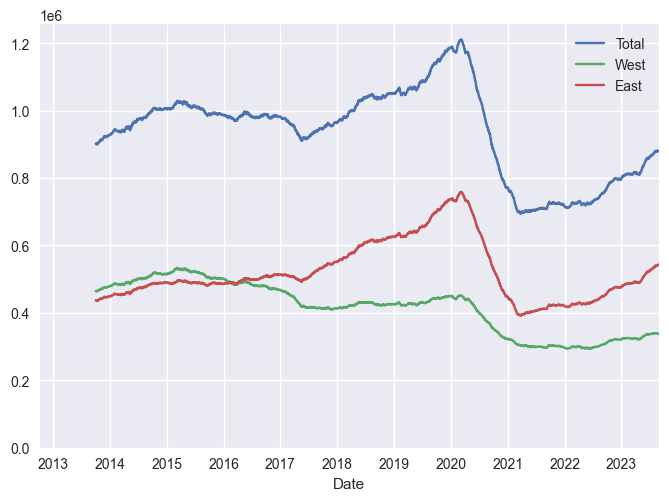

In [4]:
# summing daily data over 365 days
ax = data.resample('D').sum().rolling(365).sum().plot();

# setting axis limits for better visualization
ax.set_ylim(0,None);

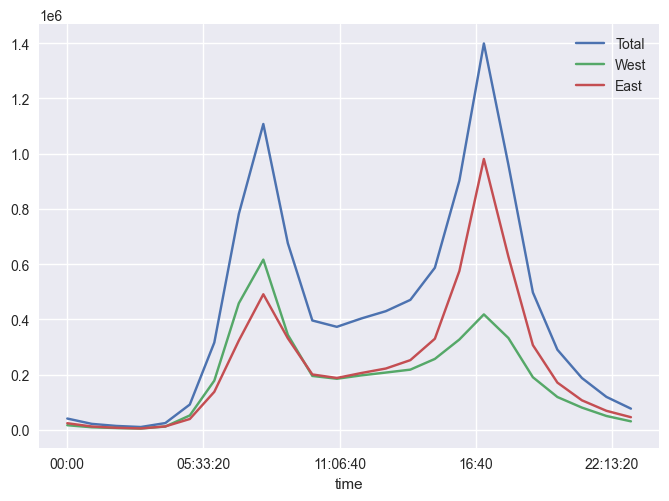

In [5]:
# Grouping data based on commute time of bicycles in a day
data.groupby(data.index.time).sum().plot();

### Drawing pivot table 

In [6]:
# Each day Vs Each hour count of bicycle tracked
pivoted = data.pivot_table('Total', index = data.index.time, columns = data.index.date)
pivoted.iloc[:5,:5]

,2012-10-03,2012-10-04,2012-10-05,2012-10-06,2012-10-07
00:00:00,13.0,18.0,11.0,15.0,11.0
01:00:00,10.0,3.0,8.0,15.0,17.0
02:00:00,2.0,9.0,7.0,9.0,3.0
03:00:00,5.0,3.0,4.0,3.0,6.0
04:00:00,7.0,8.0,9.0,5.0,3.0


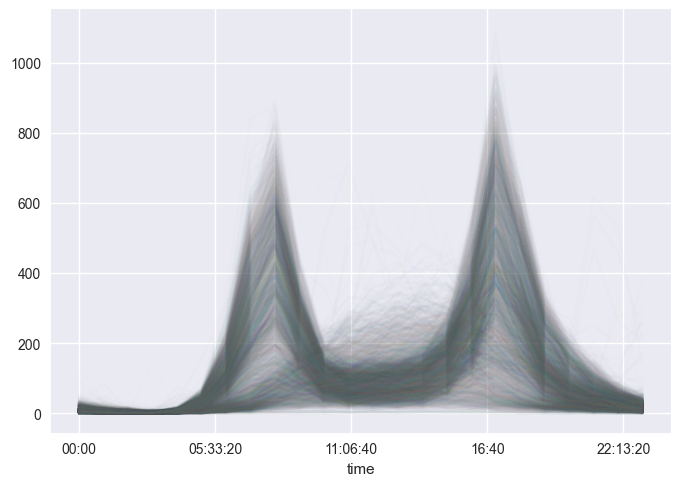

In [7]:
pivoted.plot(legend=False, alpha = 0.01);

In [8]:
# filling unavailable data with zero (0) and transposing the values
x = pivoted.fillna(0).T.values 
x.shape

(3985, 24)

### Principal Component Analysis

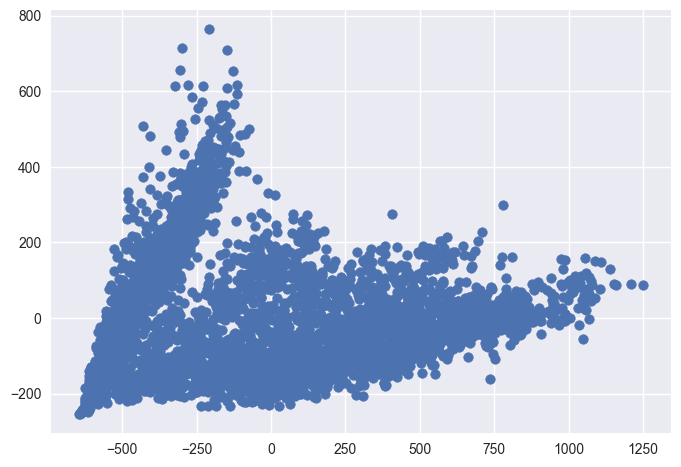

In [9]:
x2 = PCA(2, svd_solver='full').fit_transform(x)

# Scatter plot of the features
plt.scatter(x2[:,0],x2[:,1]);

### Unsupervised Clustering - Gaussian Mixture Model

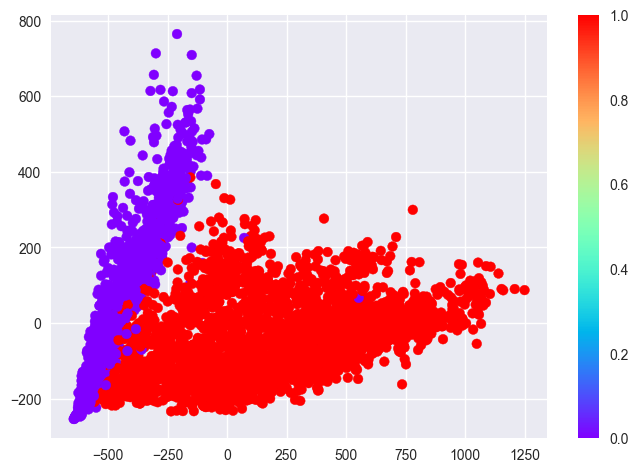

In [10]:
gm_model = GaussianMixture(2).fit(x)
labels = gm_model.predict(x)

plt.scatter(x2[:,0],x2[:,1], c=labels, cmap='rainbow')
plt.colorbar();

<Axes: title={'center': 'Red Cluster'}, xlabel='time'>

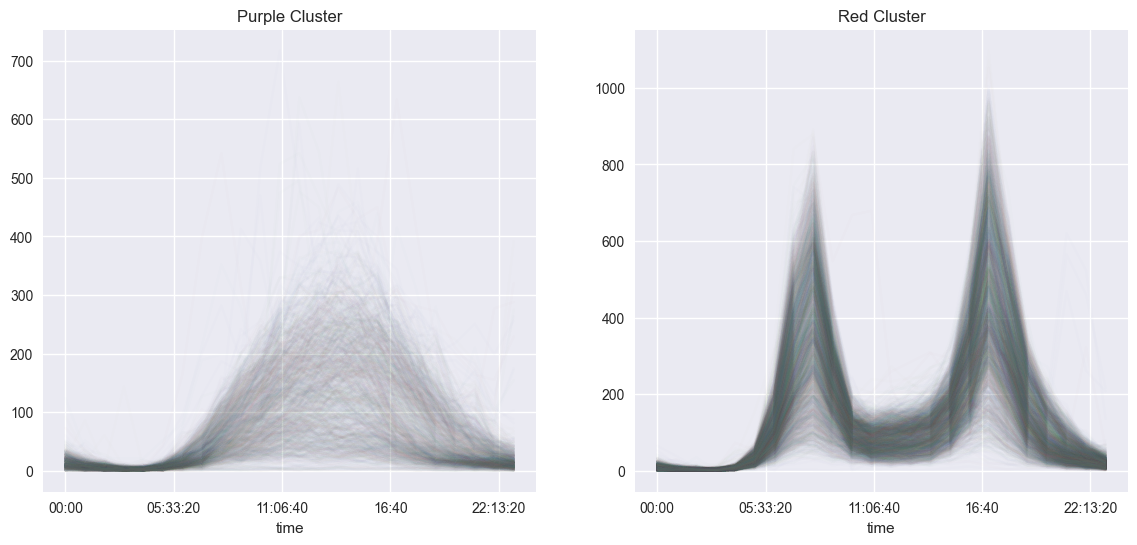

In [11]:
fig, ax = plt.subplots(1,2, figsize=(14,6))

# Commute on Weekdays
pivoted.T[labels==0].T.plot(legend=False, alpha = 0.01, ax = ax[0], title='Purple Cluster')
# Commute on Weekends and Holidays
pivoted.T[labels==1].T.plot(legend=False, alpha = 0.01, ax = ax[1], title='Red Cluster')

### Comparing with Day of the Week

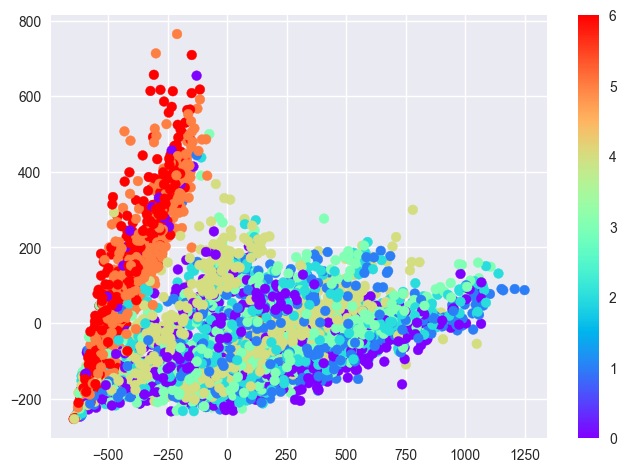

In [12]:
# calculating day of week and plotting in a scatter plot
DayOfWeek = pd.DatetimeIndex(pivoted.columns).dayofweek

plt.scatter(x2[:,0],x2[:,1], c=DayOfWeek, cmap='rainbow')
plt.colorbar()

### Analysing outliers

Identifying points which are weekdays with holiday-like pattern

In [13]:
dates = pd.DatetimeIndex(pivoted.columns)
dates [(labels == 1) & (DayOfWeek<5)]

DatetimeIndex(['2012-10-03', '2012-10-04', '2012-10-05', '2012-10-08',
               '2012-10-09', '2012-10-10', '2012-10-11', '2012-10-12',
               '2012-10-15', '2012-10-16',
               ...
               '2023-08-18', '2023-08-21', '2023-08-22', '2023-08-23',
               '2023-08-24', '2023-08-25', '2023-08-28', '2023-08-29',
               '2023-08-30', '2023-08-31'],
              dtype='datetime64[ns]', length=2736, freq=None)

What's up with '2017-02-06'? [Snow Storm](http://www.seattletimes.com/seattle-news/weather/weather-service-predicts-3-to-6-inches-of-snow-in-seattle-area/)

# The End